# VGG

**Import modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.models import Model,Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                #zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

In [3]:
train_dataset=train_datagen.flow_from_directory(directory='../input/fer2013/train',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset=valid_datagen.flow_from_directory(directory='../input/fer2013/test',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               batch_size=64)

Found 7178 images belonging to 7 classes.


In [5]:
test_dataset=test_datagen.flow_from_directory(directory='../input/fer2013/test',
                                             target_size=(48,48),
                                             batch_size=64,
                                             class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [6]:
base_model=tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [7]:
#freezing layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
#Building model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [9]:
#Model Summary
vgg_model=model
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

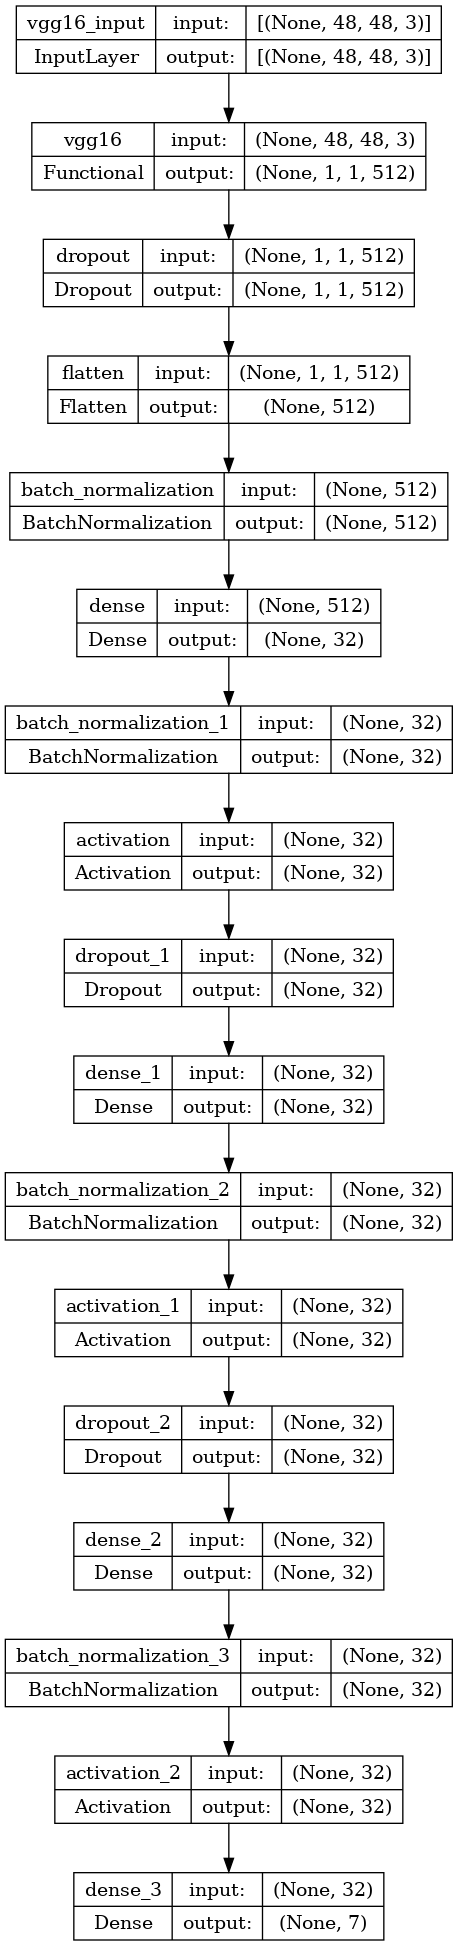

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='vgg.png',show_shapes=True,show_layer_names=True)
Image(filename='vgg.png')

In [11]:
def f1_score(y_true,y_pred): #taken from old keras source code
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
    predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))
    precision=true_positives/(predicted_positives+K.epsilon())
    recall=true_positives/(possible_positives+K.epsilon())
    f1_val=2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [13]:
lrd=ReduceLROnPlateau(monitor='val_loss',patience=20,verbose=1,factor=0.50,min_lr=0.00005)
mcp=ModelCheckpoint('vgg_model.h5')
es=EarlyStopping(verbose=1,patience=20)

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [15]:
vgg_history=vgg_model.fit(train_dataset,validation_data=valid_dataset,epochs=10,verbose=1,callbacks=[lrd,mcp,es])

Epoch 1/10


2023-06-16 18:31:41.388117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


359/359 [==============================] - 186s 482ms/step - loss: 1.9407 - accuracy: 0.8551 - precision: 0.2257 - recall: 0.0060 - auc: 0.5942 - f1_score: 0.0114 - val_loss: 1.8432 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6473 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/10
359/359 [==============================] - 59s 165ms/step - loss: 1.8356 - accuracy: 0.8569 - precision: 0.2297 - recall: 7.4016e-04 - auc: 0.6363 - f1_score: 0.0015 - val_loss: 1.7962 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6625 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/10
359/359 [==============================] - 59s 165ms/step - loss: 1.7810 - accuracy: 0.8574 - precision: 0.5435 - recall: 0.0109 - auc: 0.6722 - f1_score: 0.0210 - val_loss: 1.8607 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6430 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/10
359/359 [========

In [16]:
vgg_acc=vgg_model.evaluate(test_dataset,verbose=0)[1]
preds=vgg_model.predict(test_dataset)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_dataset.labels)
# vgg_model.save('vgg_model.h5')

113/113 [==============================] - 8s 66ms/step


**Confusion Matrix**

In [17]:
train_dir='../input/fer2013/train'
test_dir='../input/fer2013/test'

# seed=12
# IMG_HEIGHT=48
# IMG_WIDTH=48
# BATCH_SIZE=64
# EPOCHS=30
# FINE_TUNING_EPOCHS=20
# LR=0.01
# NUM_CLASSES=7
# EARLY_STOPPING_CRITERIA=3
class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

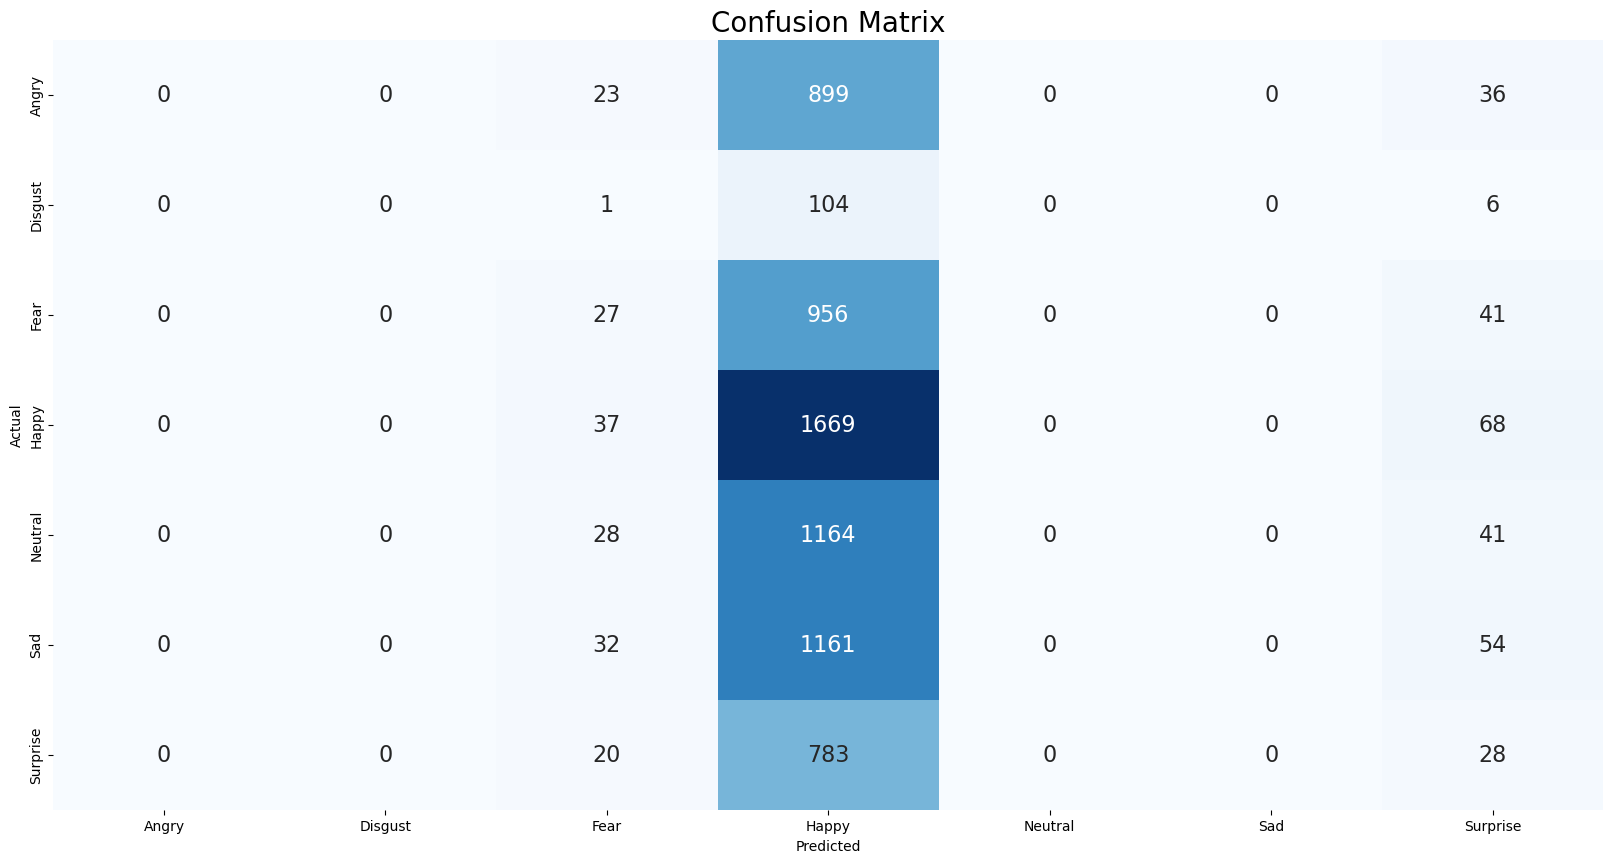

In [18]:
from sklearn.metrics import confusion_matrix,classification_report
cm_data_vgg=confusion_matrix(y_test,y_preds)
cm_vgg=pd.DataFrame(cm_data_vgg,columns=class_labels,index=class_labels)
cm_vgg.index.name="Actual"
cm_vgg.columns.name="Predicted"
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
sn.set(font_scale=1.2)
ax_vgg=sn.heatmap(cm_vgg,cbar=False,cmap="Blues",annot=True,annot_kws={"size":16},fmt='g')

**Classification Report**

In [19]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.16      0.03      0.05      1024
           3       0.25      0.94      0.39      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.10      0.03      0.05       831

    accuracy                           0.24      7178
   macro avg       0.07      0.14      0.07      7178
weighted avg       0.10      0.24      0.11      7178



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Multiclass ROC curve**

ROC AUC score: 0.6333258668641266


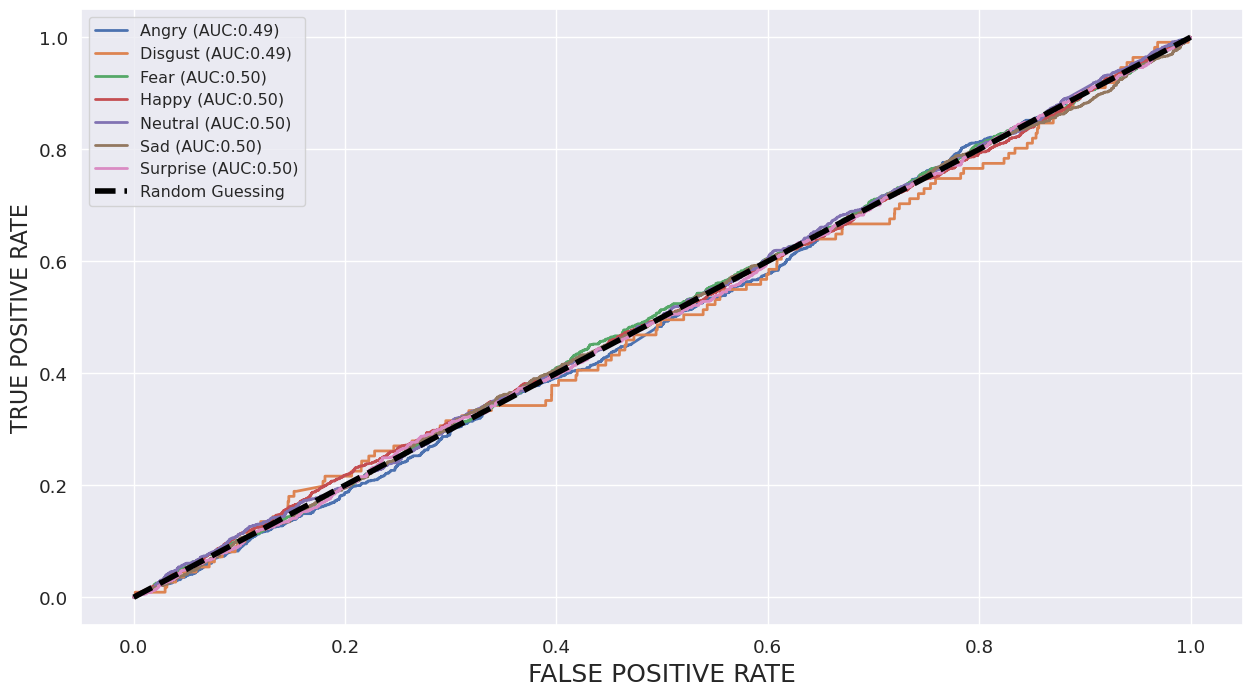

In [20]:
from sklearn.preprocessing import LabelBinarizer
fig,c_ax=plt.subplots(1,1,figsize=(15,8))
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score1(y_test,y_preds,average="macro"):
    lb=LabelBinarizer()
    lb.fit(y_test)
    y_test=lb.transform(y_test)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test[:,idx].astype(int),y_preds[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test,y_preds,average=average)

print('ROC AUC score:',multiclass_roc_auc_score1(y_test,preds,average='micro'))
plt.xlabel('FALSE POSITIVE RATE',fontsize=18)
plt.ylabel('TRUE POSITIVE RATE',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [21]:
from tensorflow.keras.utils import to_categorical
print("ROC-AUC Score =",roc_auc_score(to_categorical(y_test),preds))

ROC-AUC Score = 0.49884350620932977


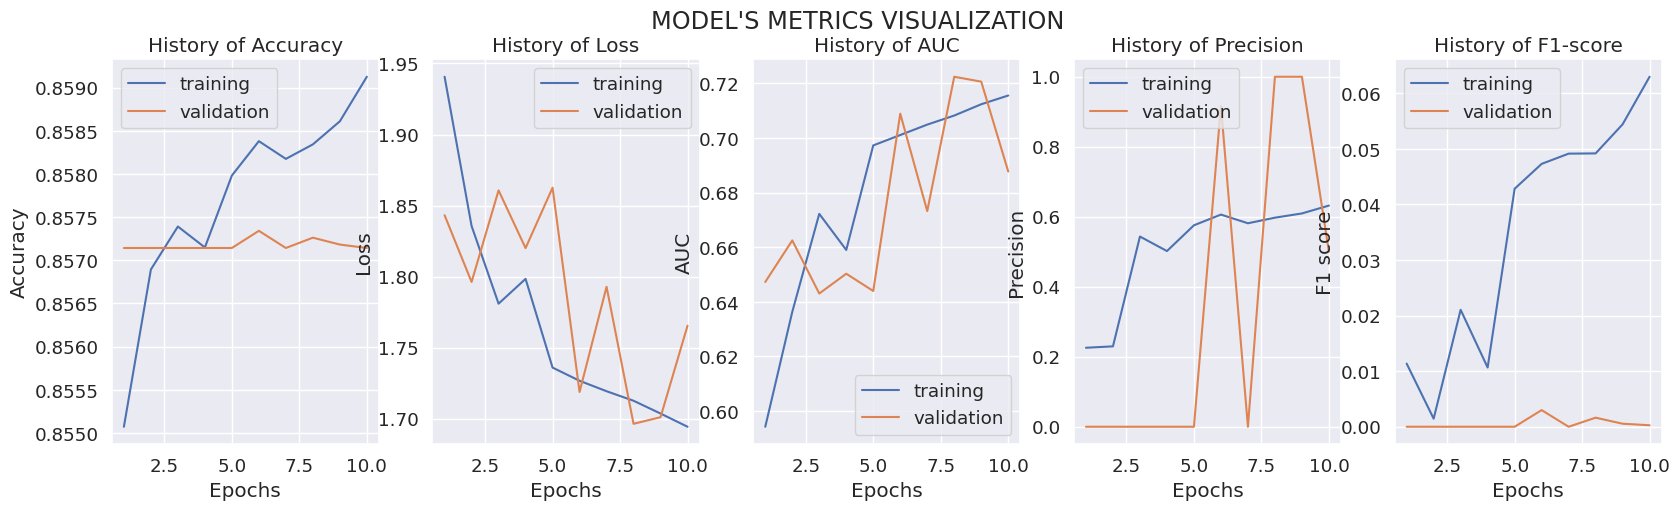

In [22]:
#plotting results
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(20,5))
    fig.suptitle("MODEL'S METRICS VISUALIZATION ")
    
    ax1.plot(range(1,len(acc)+1),acc)
    ax1.plot(range(1,len(val_acc)+1),val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training','validation'])
    
    ax2.plot(range(1,len(loss)+1),loss)
    ax2.plot(range(1,len(val_loss)+1),val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training','validation'])
    
    ax3.plot(range(1,len(auc)+1),auc)
    ax3.plot(range(1,len(val_auc)+1),val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training','validation'])
    
    ax4.plot(range(1,len(precision)+1),precision)
    ax4.plot(range(1,len(val_precision)+1),val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training','validation'])
    
    ax5.plot(range(1,len(f1)+1),f1)
    ax5.plot(range(1,len(val_f1)+1),val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training','validation'])
    
    plt.show()
    
Train_Val_Plot(vgg_history.history['accuracy'],vgg_history.history['val_accuracy'],
               vgg_history.history['loss'],vgg_history.history['val_loss'],
               vgg_history.history['auc'],vgg_history.history['val_auc'],
               vgg_history.history['precision'],vgg_history.history['val_precision'],
               vgg_history.history['f1_score'],vgg_history.history['val_f1_score']
              )

# DenseNet169 Model

In [23]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

**Hyperparametrers and Directories**

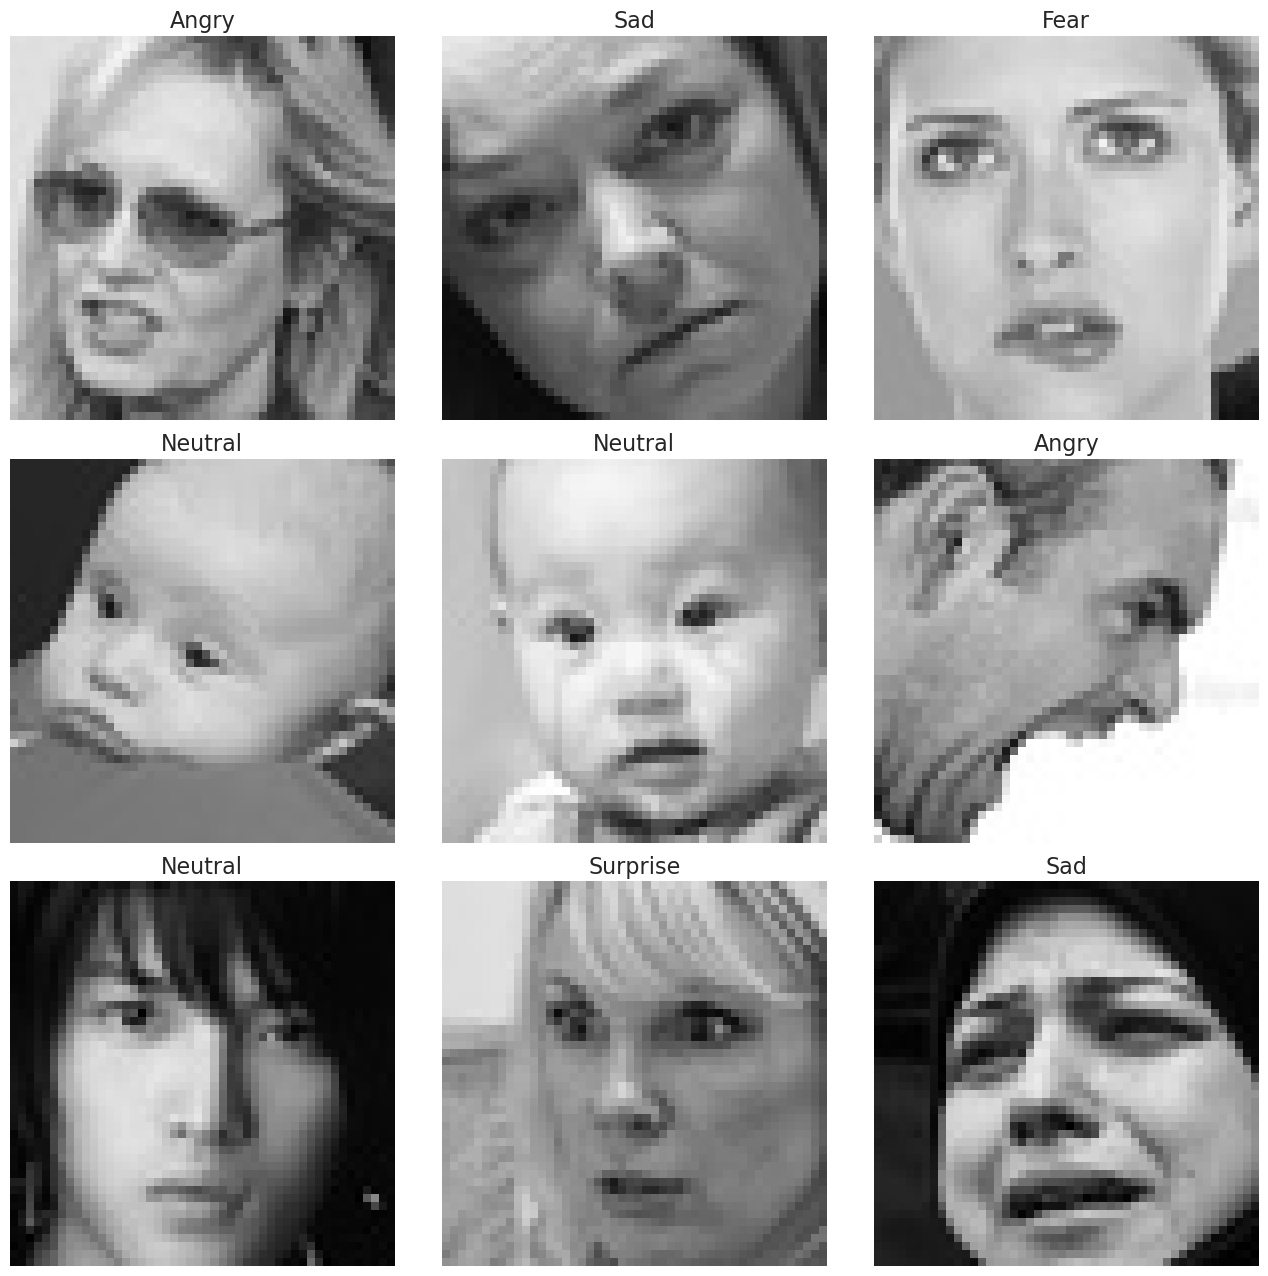

In [24]:
#Helper functions
def display_one_image(image,title,subplot,color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title,fontsize=16)
    
def display_nine_images(images,titles,title_colors=None):
    subplot=331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color='black' if title_colors is None else title_colors[i]
        display_one_image(images[i],titles[i],331+i,color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.show()
    
def image_title(label,prediction):
    #Both prediction(probabilities) and label(one-hot) are arrays with one item per class
    class_idx=np.argmax(label,axis=-1)
    prediction_idx=np.argmax(prediction,axis=-1)
    if class_idx==prediction_idx:
        return f'{class_labels[prediction_idx]} [correct]','black'
    else:
        return f'{class_labels[prediction_idx]} [incorrect, should be {class_labels[class_idx]}]','red'
    
def get_titles(images,labels,model):
    predictions=model.predict(images)
    titles,colors=[],[]
    for label,prediction in zip(classes,predictions):
        title,color=image_title(label,prediction)
        titles.append(title)
        colors.append(color)
    return titles,colors

img_datagen=ImageDataGenerator(rescale=1./255)
img_generator=img_datagen.flow_from_directory(directory=train_dir,
                                             target_size=(48,48),
                                             batch_size=64,
                                             shuffle=True,
                                             color_mode="rgb",
                                             class_mode='categorical',
                                             seed=12
                                             )
clear_output()

images,classes=next(img_generator)
class_idxs=np.argmax(classes,axis=-1)
labels=[class_labels[idx] for idx in class_idxs]
display_nine_images(images,labels)

In [25]:
import plotly.express as px
fig=px.bar(x=class_labels,
           y=[list(train_dataset.classes).count(i) for i in np.unique(train_dataset.classes)],
           color=np.unique(train_dataset.classes),
           color_continuous_scale='Emrld')
fig.update_xaxes(title='Emotions')
fig.update_yaxes(title='Number of Images')
fig.update_layout(showlegend=True,
                 title={
                     'text':'Train Data Distribution ',
                     'y':0.95,
                     'x':0.5,
                     'xanchor':'center',
                     'yanchor':'top'
                 })
fig.show()

**DenseNet169 Transfer Learning**

In [26]:
def feature_extractor(inputs):
    feature_extractor=tf.keras.applications.DenseNet169(input_shape=(48,48,3),include_top=False,weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x=tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x=tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x=tf.keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(7,activation='softmax',name='classification')(x)
    return x

def final_model(inputs):
    densenet_feature_extractor=feature_extractor(inputs)
    classification_output=classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs=tf.keras.layers.Input(shape=(48,48,3))
    classification_output=final_model(inputs)
    densenet_model=tf.keras.Model(inputs=inputs,outputs=classification_output)
    densenet_model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
    
    return densenet_model

**Summary**

In [27]:
densenet_model=define_compile_model()
clear_output()

#Freezing the feature extraction layers
densenet_model.layers[1].trainable=False

densenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 256)               426240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                             

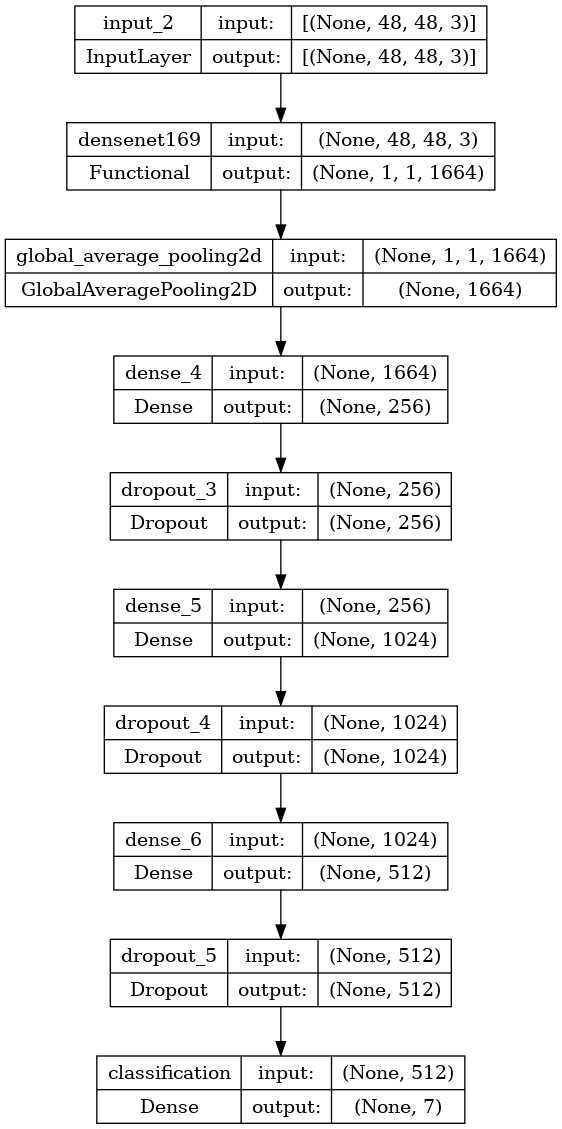

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(densenet_model,to_file='densenet.png',show_shapes=True,show_layer_names=True)
Image(filename='densenet.png')

In [29]:
densenet_history=densenet_model.fit(x=train_dataset,
                                   epochs=30,
                                   validation_data=valid_dataset,
                                   callbacks=[lrd,es])
densenet_history=pd.DataFrame(densenet_history.history)

Epoch 1/30
359/359 [==============================] - 137s 221ms/step - loss: 9.9593 - accuracy: 0.2699 - val_loss: 5.4359 - val_accuracy: 0.2931 - lr: 0.1000
Epoch 2/30
359/359 [==============================] - 71s 198ms/step - loss: 3.5582 - accuracy: 0.3565 - val_loss: 3.1603 - val_accuracy: 0.3424 - lr: 0.1000
Epoch 3/30
359/359 [==============================] - 72s 199ms/step - loss: 1.9724 - accuracy: 0.4117 - val_loss: 2.0413 - val_accuracy: 0.3578 - lr: 0.1000
Epoch 4/30
359/359 [==============================] - 72s 201ms/step - loss: 1.5604 - accuracy: 0.4402 - val_loss: 1.5294 - val_accuracy: 0.4409 - lr: 0.1000
Epoch 5/30
359/359 [==============================] - 72s 200ms/step - loss: 1.4649 - accuracy: 0.4524 - val_loss: 1.5753 - val_accuracy: 0.4040 - lr: 0.1000
Epoch 6/30
359/359 [==============================] - 72s 201ms/step - loss: 1.4073 - accuracy: 0.4758 - val_loss: 1.4103 - val_accuracy: 0.4851 - lr: 0.1000
Epoch 7/30
359/359 [==============================]

**Fine Tuning**

In [30]:
#Un-freezing the feature extraction layers for fine tuning
densenet_model.layers[1].trainable=True

densenet_model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
densenet_history_=densenet_model.fit(x=train_dataset,epochs=20,validation_data=valid_dataset)
# densenet_history=densenet_history.append(pd.DataFrame(densenet_history_,densenet_history),ignore_index=True)

Epoch 1/20
359/359 [==============================] - 124s 209ms/step - loss: 1.0792 - accuracy: 0.6305 - val_loss: 1.1224 - val_accuracy: 0.6092
Epoch 2/20
359/359 [==============================] - 73s 202ms/step - loss: 1.0554 - accuracy: 0.6428 - val_loss: 1.1071 - val_accuracy: 0.6158
Epoch 3/20
359/359 [==============================] - 76s 211ms/step - loss: 1.0350 - accuracy: 0.6464 - val_loss: 1.1020 - val_accuracy: 0.6154
Epoch 4/20
359/359 [==============================] - 73s 204ms/step - loss: 1.0295 - accuracy: 0.6488 - val_loss: 1.0956 - val_accuracy: 0.6173
Epoch 5/20
359/359 [==============================] - 74s 205ms/step - loss: 1.0162 - accuracy: 0.6535 - val_loss: 1.0932 - val_accuracy: 0.6202
Epoch 6/20
359/359 [==============================] - 74s 205ms/step - loss: 1.0169 - accuracy: 0.6512 - val_loss: 1.0871 - val_accuracy: 0.6206
Epoch 7/20
359/359 [==============================] - 73s 203ms/step - loss: 1.0095 - accuracy: 0.6544 - val_loss: 1.0840 - val_a

**Training Plots**

In [31]:
x=px.line(data_frame=densenet_history,y=['accuracy','val_accuracy'],markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title='Accuracy')
x.update_layout(showlegend=True,
               title={
                   'text':'Accuracy vs Number of Epochs',
                   'y':0.94,
                   'x':0.5,
                   'xanchor':'center',
                   'yanchor':'top'
               })
x.show()

In [32]:
x=px.line(data_frame=densenet_history,y=['loss','val_loss'],markers=True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title='Loss')
x.update_layout(showlegend=True,
               title={
                   'text':'Loss vs Number of Epochs',
                   'y':0.94,
                   'x':0.5,
                   'xanchor':'center',
                   'yanchor':'top'
               })
x.show()

**Visualizing Results**

Model Evaluation

In [33]:
densenet_model.evaluate(test_dataset)
preds1=densenet_model.predict(test_dataset)
y_preds1=np.argmax(preds1,axis=1)
y_test1=np.array(test_dataset.labels)

113/113 [==============================] - 11s 73ms/step


**Confusion Matrix**

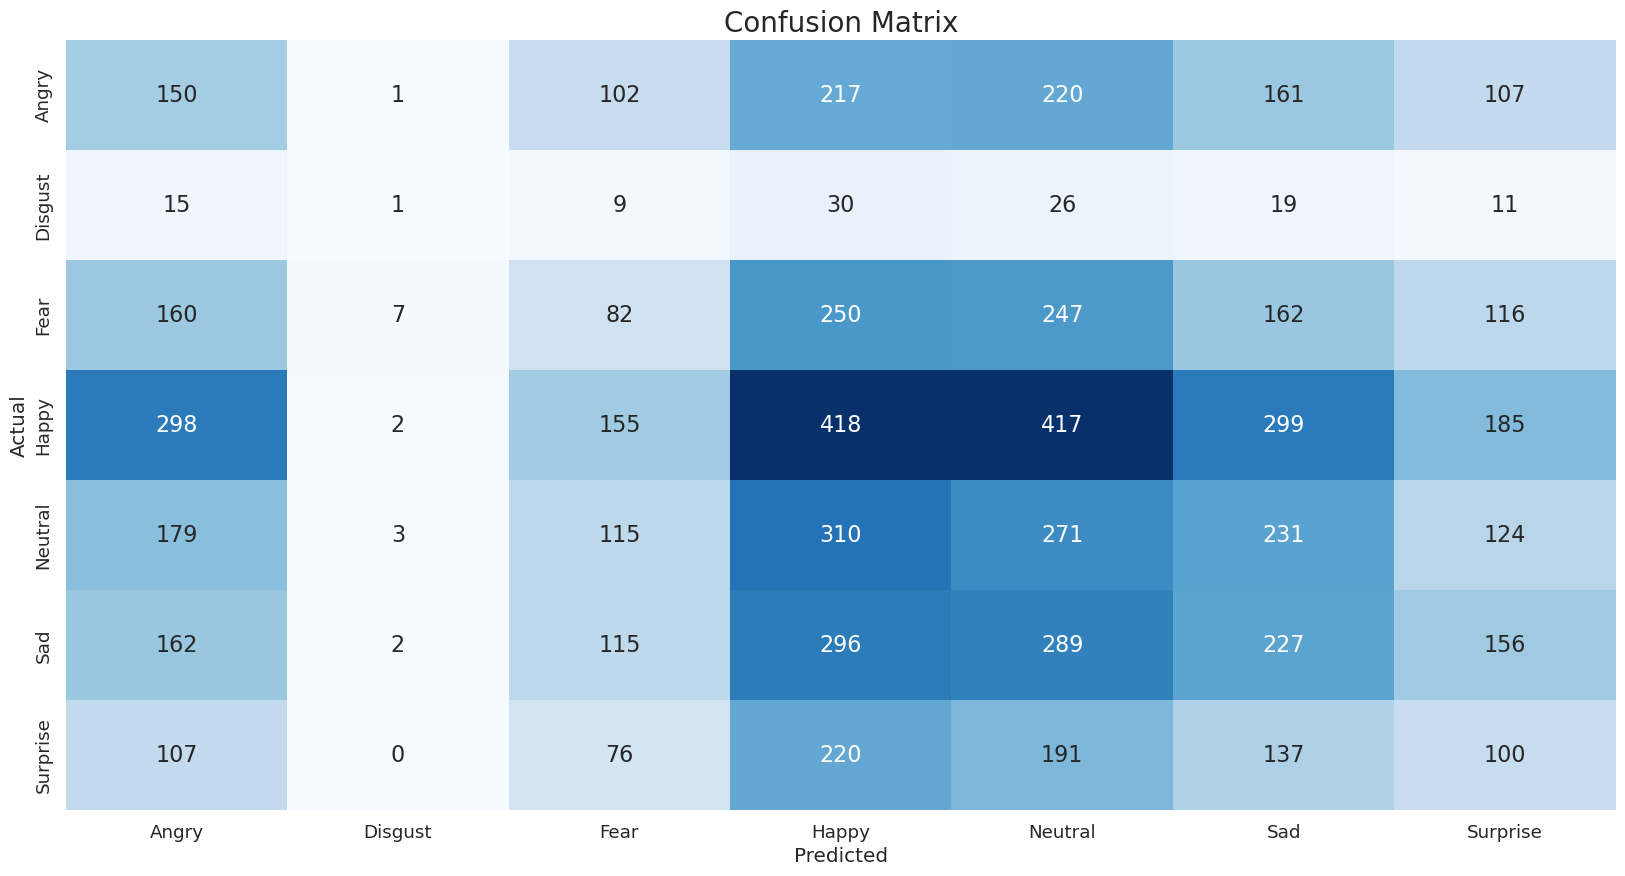

In [34]:
cm_data=confusion_matrix(y_test1,y_preds1)
cm=pd.DataFrame(cm_data,columns=class_labels,index=class_labels)
cm.index.name='Actual'
cm.columns.name='Predicted'
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
ax=sn.heatmap(cm,cbar=False,cmap='Blues',annot=True,annot_kws={"size":16},fmt='g')

**Classification Report**

In [35]:
print(classification_report(y_test1,y_preds1))

              precision    recall  f1-score   support

           0       0.14      0.16      0.15       958
           1       0.06      0.01      0.02       111
           2       0.13      0.08      0.10      1024
           3       0.24      0.24      0.24      1774
           4       0.16      0.22      0.19      1233
           5       0.18      0.18      0.18      1247
           6       0.13      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



**Multiclass AUC Curve**

ROC AUC score: 0.5550051765190807


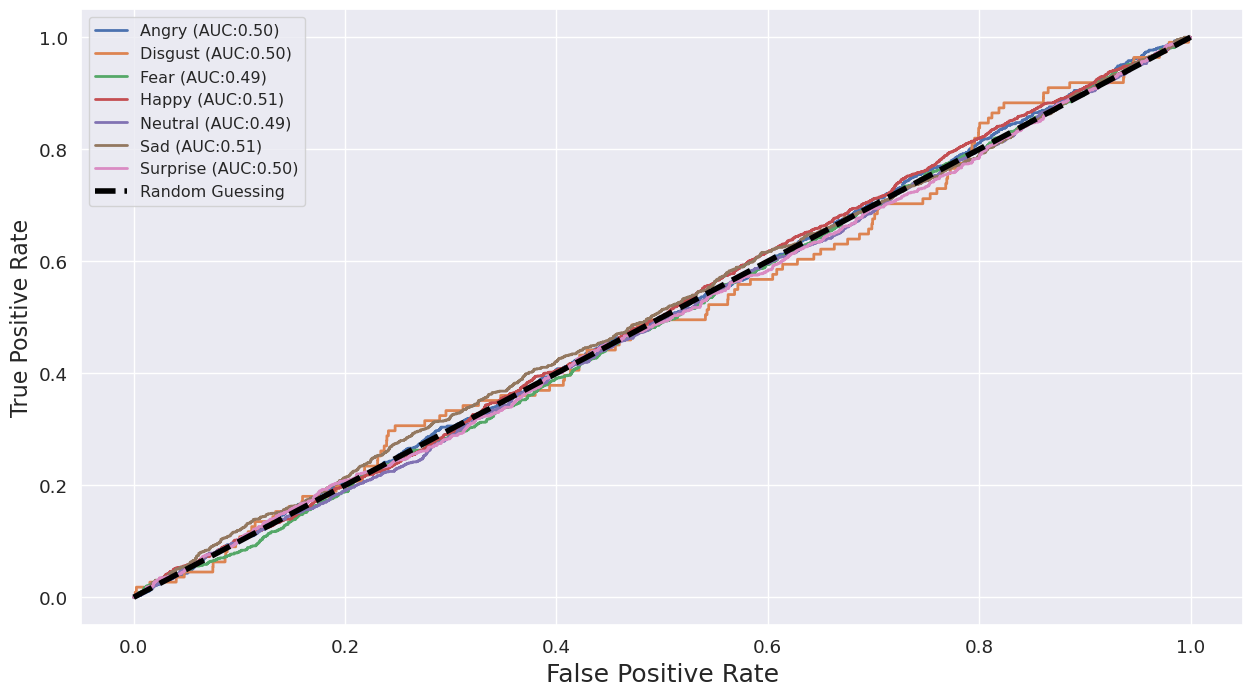

In [36]:
fig,c_ax=plt.subplots(1,1,figsize=(15,8))

def multiclass_roc_auc_score(y_test1,y_preds1,average='macro'):
    lb=LabelBinarizer()
    lb.fit(y_test1)
    y_test1=lb.transform(y_test1)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test1[:,idx].astype(int),y_preds1[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test1,y_preds1,average=average)

print('ROC AUC score:',multiclass_roc_auc_score(y_test1,preds1,average='micro'))
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [37]:
from tensorflow.keras.utils import to_categorical
print("ROC-AUC Score = ",roc_auc_score(to_categorical(y_test1),preds))

ROC-AUC Score =  0.49884350620932977


# ResNet50

In [38]:
base_model1=tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 1s 0us/step


In [39]:
#Freezing layers

for layer in base_model1.layers[:4]:
    layer.trainable=False

**Building Model**

In [40]:
model_resnet=Sequential()
model_resnet.add(base_model1)
model_resnet.add(Dropout(0.5))
model_resnet.add(Flatten())
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dense(7,activation='softmax'))

#model summary
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_6 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

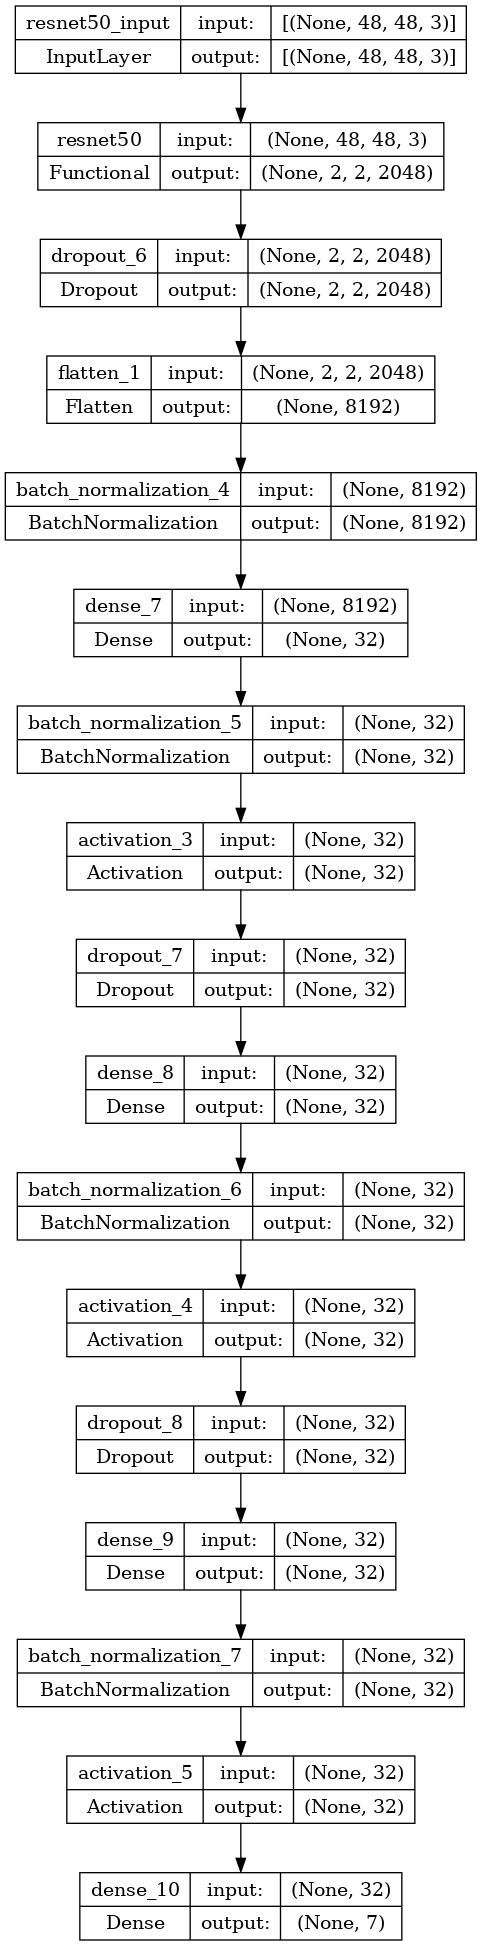

In [41]:
plot_model(model_resnet,to_file='model_resnet.png',show_shapes=True,show_layer_names=True)
Image(filename='model_resnet.png')

In [42]:
mcp1=ModelCheckpoint('model_resnet.h5')

In [43]:
model_resnet.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [44]:
history_resnet=model_resnet.fit(train_dataset,validation_data=valid_dataset,epochs=60,verbose=1,callbacks=[lrd,mcp1,es])

Epoch 1/60


2023-06-16 19:55:43.253256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


359/359 [==============================] - 112s 188ms/step - loss: 1.9160 - accuracy: 0.8548 - precision: 0.2155 - recall: 0.0062 - auc: 0.6352 - f1_score: 0.0152 - val_loss: 2.3820 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5698 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - 66s 183ms/step - loss: 1.8424 - accuracy: 0.8559 - precision: 0.2082 - recall: 0.0031 - auc: 0.6349 - f1_score: 0.0060 - val_loss: 11.0883 - val_accuracy: 0.7474 - val_precision: 0.1158 - val_recall: 0.1158 - val_auc: 0.4842 - val_f1_score: 0.1164 - lr: 0.0010
Epoch 3/60
359/359 [==============================] - 66s 184ms/step - loss: 1.8274 - accuracy: 0.8565 - precision: 0.1883 - recall: 0.0013 - auc: 0.6408 - f1_score: 0.0025 - val_loss: 47.0395 - val_accuracy: 0.7474 - val_precision: 0.1158 - val_recall: 0.1158 - val_auc: 0.4842 - val_f1_score: 0.1157 - lr: 0.0010
Epoch 4/60
359/359 [==============================] - 

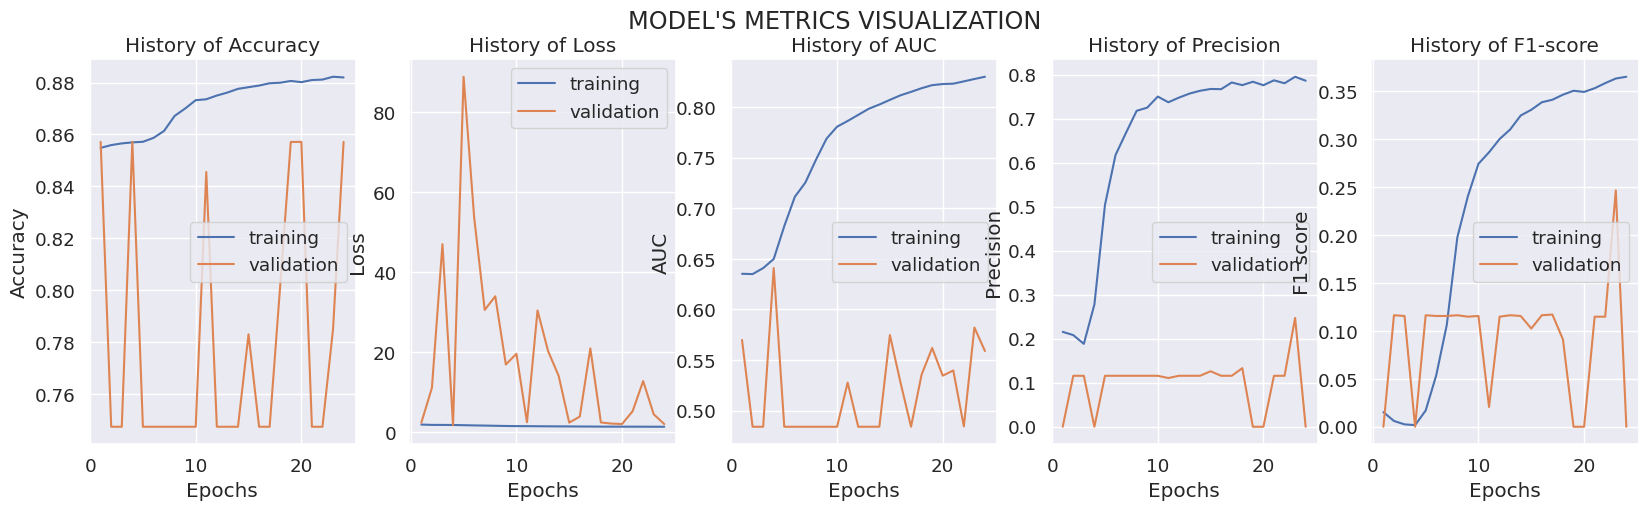

In [45]:
#plotting results
Train_Val_Plot(history_resnet.history['accuracy'],history_resnet.history['val_accuracy'],
               history_resnet.history['loss'],history_resnet.history['val_loss'],
               history_resnet.history['auc'],history_resnet.history['val_auc'],
               history_resnet.history['precision'],history_resnet.history['val_precision'],
               history_resnet.history['f1_score'],history_resnet.history['val_f1_score']
              )